<a href="https://colab.research.google.com/github/SartJ/AI-Fun/blob/main/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer using PyTorch

In [ ]:
!pip install torch torchvision

Importing some images:

In [ ]:
!git clone https://github.com/parth1620/Project-NST.git

Cloning into 'Project-NST'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


Loading VGG Pretrained Model:

In [ ]:
import torch
from torchvision import models

vgg = models.vgg19(pretrained = True)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

We remove the classifier part because we are going to extract the content and the style features from the feature part.

In [ ]:
vgg = vgg.features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Now we make the gradients 'false' or freeze the model because we are not going to compute the gradients to update any weights or biases in the model, we are just going to use the pretrained weights.

In [ ]:
for parameters in vgg.parameters():
  parameters.requires_grad_(False)

We use CUDA in pytorch to move our variables and model to GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Preprocessing Image:

In [ ]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size = 500):
  image = Image.open(img_path).convert('RGB')

  if max(image.size) > max_size:
    size = max_size

  else:
    size = max(image.size)

  # https://pytorch.org/vision/stable/models.html
  img_transforms = T.Compose([
                              T.Resize(size),
                              T.ToTensor(), # (224,224,3) -> (3,224,224)
                              T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
  ])
  image = img_transforms(image)

  image = image.unsqueeze(0) #(3, 224, 224) -> (1, 3, 224, 224) => (batch size, channels, H, W)

  return image

In [ ]:
pp_content = preprocess('/content/Project-NST/content10.jpg')
pp_style = preprocess('/content/Project-NST/style10.jpg')

pp_content = pp_content.to(device)
pp_style = pp_style.to(device)

print("Content Shape", pp_content.shape)
print("Style Shape", pp_style.shape)

Content Shape torch.Size([1, 3, 487, 487])
Style Shape torch.Size([1, 3, 500, 765])


Deprocessing Image:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):

  image = tensor.to('cpu').clone()
  image = image.numpy()
  image = image.squeeze(0) # (1,3,224,224) -> (3,224,224)
  image = image.transpose(1,2,0) #(3,224,224) -> (224,224,3)
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0,1)

  return image

In [ ]:
dp_content = deprocess(pp_content)
dp_style = deprocess(pp_style)

print("Deprocessed Content Shape", dp_content.shape)
print("Deprocessed Style Shape", dp_style.shape)

Deprocessed Content Shape (487, 487, 3)
Deprocessed Style Shape (500, 765, 3)


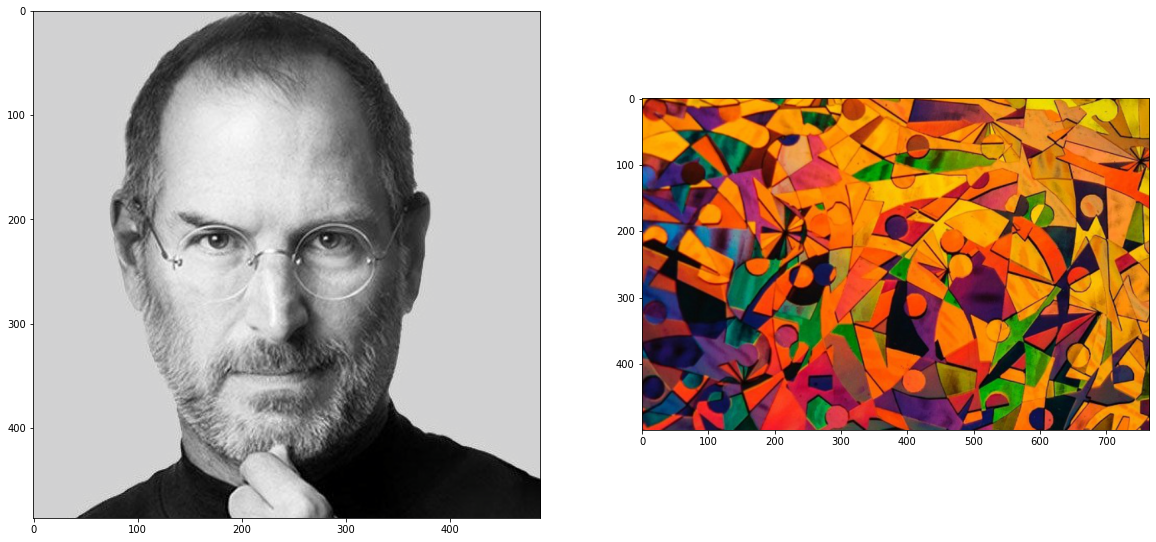

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (20,10))

ax1.imshow(dp_content)
ax2.imshow(dp_style)

Get content, style features and create gram matrix:

In [ ]:
def get_features(image, model):
  layers = {
      '0' : 'conv1_1',
      '5' : 'conv2_1',
      '10' : 'conv3_1',
      '19' : 'conv4_1',
      '21' : 'conv4_2', #content_feature
      '28' : 'conv5_1'
  }

  x = image

  Features = {}

  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      Features[layers[name]] = x
  return Features

In [ ]:
f_content = get_features(pp_content, vgg)
f_style = get_features(pp_style, vgg)

In [ ]:
def gram_matrix(tensor):

  b,c,h,w = tensor.size()
  tensor = tensor.view(c, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [ ]:
style_grams = {layer : gram_matrix(f_style[layer]) for layer in f_style}

Creating Style and Content loss function:

In [ ]:
def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss

In [ ]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2,
    
}

In [ ]:
def style_loss(style_weights, target_features, style_grams):
  loss = 0
  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b,c,h,w = target_f.shape
    layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    loss += layer_loss/(c*h*w)

  return loss

In [ ]:
target = pp_content.clone().requires_grad_(True).to(device)
target_f = get_features(target, vgg)
print("Content Loss:", content_loss(target_f['conv4_2'],f_content['conv4_2']))
print("Style Loss:", style_loss(style_weights, target_f, style_grams))

Content Loss: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Style Loss: tensor(3823.5757, device='cuda:0', grad_fn=<AddBackward0>)


Training Loop:

In [ ]:
from torch import optim

optimizer = optim.Adam([target], lr = 0.003)

alpha = 1
beta = 1e5

epochs = 3000
show_every = 500

In [ ]:
def total_loss(c_loss, s_loss, alpha, beta):
  loss = alpha * c_loss + beta * s_loss
  return loss

In [ ]:
results = []

for i in range(epochs):
  target_f = get_features(target, vgg)

  c_loss = content_loss(target_f['conv4_2'], f_content['conv4_2'])
  s_loss = style_loss(style_weights, target_f, style_grams)
  t_loss = total_loss(c_loss, s_loss, alpha, beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print("Total Loss at Epoch {} : {}".format(i, t_loss))
    results.append(deprocess(target.detach()))

Total Loss at Epoch 0 : 382357568.0
Total Loss at Epoch 500 : 100316176.0
Total Loss at Epoch 1000 : 54227468.0
Total Loss at Epoch 1500 : 26046696.0
Total Loss at Epoch 2000 : 13544551.0
Total Loss at Epoch 2500 : 8142534.5


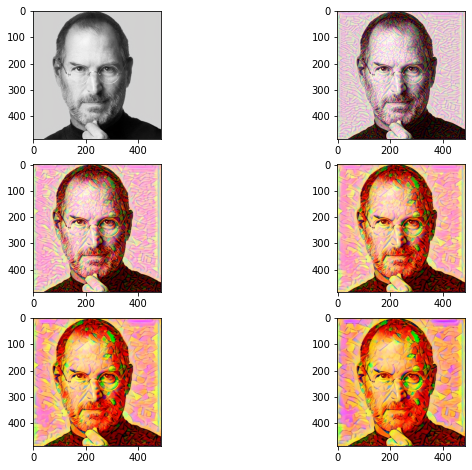

In [ ]:
plt.figure(figsize = (10,8))

for i in range(len(results)):
  plt.subplot(3,2,i+1)
  plt.imshow(results[i])
plt.show()

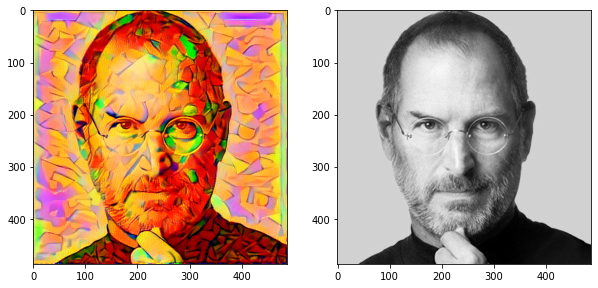

In [ ]:
target_copy = deprocess(target.detach())
content_copy = deprocess(pp_content)

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy)